##### <p> Samuel Wolfe <br> July 18th, 2023 <br> MSBA 206 <br> DMBA Chapter 7 Homework 7.2 & 7.3 </p>

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import requests
import io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import matplotlib.pylab as plt
import numpy as np

In [2]:
def readFile(url):
    download = requests.get(url).content
    # Reading the downloaded content and turning it into a pandas dataframe
    df = pd.read_csv(io.StringIO(download.decode('utf-8')))
    return df
def statslist(df):
    dfStats = pd.DataFrame({'Mean' : df.mean(numeric_only=True),
            'SD' : df.std(numeric_only=True),
            'Min' : df.min(),
            'Max' : df.max(),
            'Median' : df.median(numeric_only=True),
            })
    return dfStats

# 7.2

#### Import the data

In [3]:
dfBank = readFile("https://raw.githubusercontent.com/wolfesamk/MSBA-206/main/dmba/UniversalBank.csv")
dfBank['Education'] = dfBank['Education'].astype('category')
dfBank = pd.get_dummies(dfBank, prefix_sep='_', drop_first=False)
print(dfBank.shape)
dfBank.head(5)

(5000, 16)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Education_1,Education_2,Education_3
0,1,25,1,49,91107,4,1.6,0,0,1,0,0,0,1,0,0
1,2,45,19,34,90089,3,1.5,0,0,1,0,0,0,1,0,0
2,3,39,15,11,94720,1,1.0,0,0,0,0,0,0,1,0,0
3,4,35,9,100,94112,1,2.7,0,0,0,0,0,0,0,1,0
4,5,35,8,45,91330,4,1.0,0,0,0,0,0,1,0,1,0


#### Split into 60/40

In [4]:
bank_trainData, bank_validData = train_test_split(dfBank, test_size=0.4, random_state=1)
print(bank_trainData.shape, bank_validData.shape)

(3000, 16) (2000, 16)


#### Creating customer

In [5]:
newCustomer = pd.DataFrame([{'Age': 40, 'Experience': 10, 'Income': 84, 'Family': 2, 'CCAvg': 2, 'Mortgage': 0,
                         'Securities Account': 0, 'CD Account': 0, 'Online': 1, 'CreditCard': 1, 'Education_1': 0,
                         'Education_2': 1, 'Education_3': 0}],
                       columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities Account',
                                'CD Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
newCustomer

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities Account,CD Account,Online,CreditCard,Education_1,Education_2,Education_3
0,40,10,84,2,2,0,0,0,1,1,0,1,0


In [6]:
outcome = 'Personal Loan'
predictors = list(dfBank.columns.drop(['ID','ZIP Code']))
predictors.remove(outcome)
scaler = preprocessing.StandardScaler()
print(predictors)

['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3']


#### Normalizing data

In [7]:
scaler.fit(bank_trainData[predictors])
#scaler.transform(train_df[predictors])
# Transform the predictors of training, validation and newCustomer
bank_train_X = scaler.transform(bank_trainData[predictors])
bank_train_y = bank_trainData[outcome]
bank_valid_X = scaler.transform(bank_validData[predictors])
bank_valid_y = bank_validData[outcome]
newCustomerNorm = pd.DataFrame(scaler.transform(newCustomer), 
                               columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities Account',
                                   'CD Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
print(newCustomerNorm)

        Age  Experience    Income    Family     CCAvg  Mortgage  \
0 -0.486446   -0.901063  0.220892 -0.352127  0.035689 -0.559242   

   Securities Account  CD Account   Online  CreditCard  Education_1  \
0           -0.337025   -0.252646  0.83419     1.53728    -0.838795   

   Education_2  Education_3  
0     1.591719    -0.660895  


#### 7.2.a knn k=1 success class of 1 for loan acceptance cutoff of 0.5

In [8]:
knn1 = KNeighborsClassifier(n_neighbors=1).fit(bank_train_X, bank_train_y)
distances, indices = knn1.kneighbors(newCustomerNorm.values)
print(knn1.predict(newCustomerNorm.values))
print('Distances',distances)
print('Indices',indices)
print('Training Data\n',bank_trainData.iloc[indices[0], :])

[0]
Distances [[0.49507362]]
Indices [[1557]]
Training Data
         ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Mortgage  \
4407  4408   37          13      71     90755       2    1.7         0   

      Personal Loan  Securities Account  CD Account  Online  CreditCard  \
4407              0                   0           0       1           1   

      Education_1  Education_2  Education_3  
4407            0            1            0  


In [9]:
classificationSummary(bank_valid_y, knn1.predict(bank_valid_X))

Confusion Matrix (Accuracy 0.9545)

       Prediction
Actual    0    1
     0 1785   22
     1   69  124


#### I believe this is correct, and is telling me that the new customer would be classified as not taking the personal loan.

#### 7.2.b Given that K == 1 gives an accuracy of 95.45% I am inclined to think 1 is sufficient.

In [10]:
results = []
for k in range(1,15):
    knnR = KNeighborsClassifier(n_neighbors=k).fit(bank_train_X, bank_train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(bank_valid_y, knnR.predict(bank_valid_X))
    })
results = pd.DataFrame(results).sort_values(by=['accuracy'],ascending=False)
print(results)

     k  accuracy
4    5    0.9565
0    1    0.9545
2    3    0.9535
6    7    0.9520
1    2    0.9500
3    4    0.9495
5    6    0.9495
8    9    0.9475
10  11    0.9465
7    8    0.9460
12  13    0.9450
9   10    0.9435
11  12    0.9435
13  14    0.9435


#### Yes, k==1 is sufficient. But looking at the values generated we can see that k==5 has slightly improved performance.

#### 7.2.c

In [11]:
knn5 = KNeighborsClassifier(n_neighbors=5).fit(bank_train_X, bank_train_y)
classificationSummary(bank_valid_y, knn5.predict(bank_valid_X))

Confusion Matrix (Accuracy 0.9565)

       Prediction
Actual    0    1
     0 1803    4
     1   83  110


#### 7.2.d

In [12]:
newCustomer = pd.DataFrame([{'Age': 40, 'Experience': 10, 'Income': 84, 'Family': 2, 'CCAvg': 2, 'Mortgage': 0,
                         'Securities Account': 0, 'CD Account': 0, 'Online': 1, 'CreditCard': 1, 'Education_1': 0,
                         'Education_2': 1, 'Education_3': 0}],
                       columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities Account',
                                'CD Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
newCustomer

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities Account,CD Account,Online,CreditCard,Education_1,Education_2,Education_3
0,40,10,84,2,2,0,0,0,1,1,0,1,0


In [13]:
distances, indices = knn5.kneighbors(newCustomerNorm.values)
print(knn5.predict(newCustomerNorm.values))
print('Distances',distances)
print('Indices',indices)
print('Training Data\n',bank_trainData.iloc[indices[0], :])

[0]
Distances [[0.49507362 0.63219765 0.93477446 1.17852337 1.32753093]]
Indices [[1557 1087 1690 2408 2255]]
Training Data
         ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Mortgage  \
4407  4408   37          13      71     90755       2   1.70         0   
3398  3399   40          14      62     92028       2   2.40         0   
2913  2914   39          12      75     94501       3   2.33         0   
2086  2087   36          12      84     90291       1   0.80         0   
4487  4488   38          14      81     94583       1   3.60         0   

      Personal Loan  Securities Account  CD Account  Online  CreditCard  \
4407              0                   0           0       1           1   
3398              0                   0           0       1           1   
2913              0                   0           0       1           1   
2086              0                   0           0       1           1   
4487              0                   0           0    

#### Interesting, seems the 0.1% gain from using k==1 doesnt pay off.

#### 7.2.e

In [14]:
bank_trainData, bank_TempData = train_test_split(dfBank, test_size=0.5, random_state=1)
bank_validData, bank_testData = train_test_split(bank_TempData, test_size=0.4, random_state=1)
print(bank_trainData.shape, bank_validData.shape, bank_testData.shape)

(2500, 16) (1500, 16) (1000, 16)


In [15]:
scaler = preprocessing.StandardScaler()
scaler.fit(bank_trainData[predictors])
#scaler.transform(train_df[predictors])
# Transform the predictors of training, validation and newCustomer
bank_train_X = scaler.transform(bank_trainData[predictors])
bank_train_y = bank_trainData[outcome]
bank_valid_X = scaler.transform(bank_validData[predictors])
bank_valid_y = bank_validData[outcome]
bank_test_X = scaler.transform(bank_testData[predictors])
bank_test_y = bank_testData[outcome]

In [16]:
knn5 = KNeighborsClassifier(n_neighbors=5).fit(bank_train_X, bank_train_y)

In [17]:
classificationSummary(bank_train_y, knn5.predict(bank_train_X))

Confusion Matrix (Accuracy 0.9684)

       Prediction
Actual    0    1
     0 2255    4
     1   75  166


In [19]:
classificationSummary(bank_valid_y, knn5.predict(bank_valid_X))

Confusion Matrix (Accuracy 0.9533)

       Prediction
Actual    0    1
     0 1346    3
     1   67   84


In [20]:
classificationSummary(bank_test_y, knn5.predict(bank_test_X))

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual   0   1
     0 907   5
     1  35  53


#### It appears that with the validation set the model fit better than with the test set. This is okay though as both still have high accuracy. The differences come from the fact they are two different datasets being compared against the training model.

#### Gains and Lift Charts

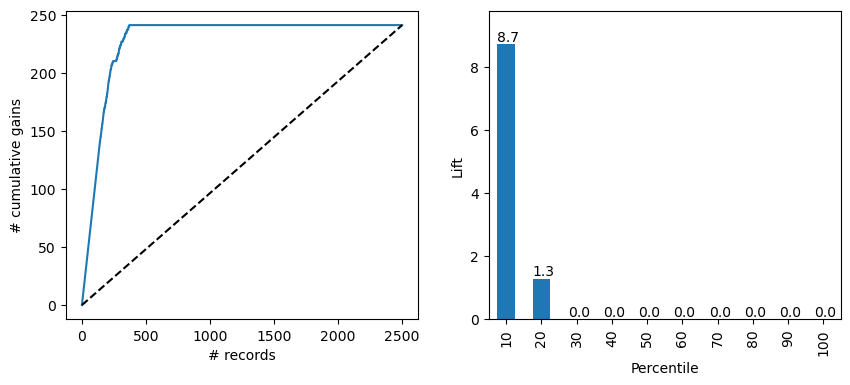

In [23]:
proba = knn5.predict_proba(bank_train_X)
result = pd.DataFrame({'actual': bank_train_y, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': knn5.predict(bank_train_X) })
df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False)
plt.show()

#### The gains above chart shows us the results are much better than random and that we stand to lift by 8.7 and 1.3 for the first two percentiles using the model. This is the test data though so such high returns are to be expected.

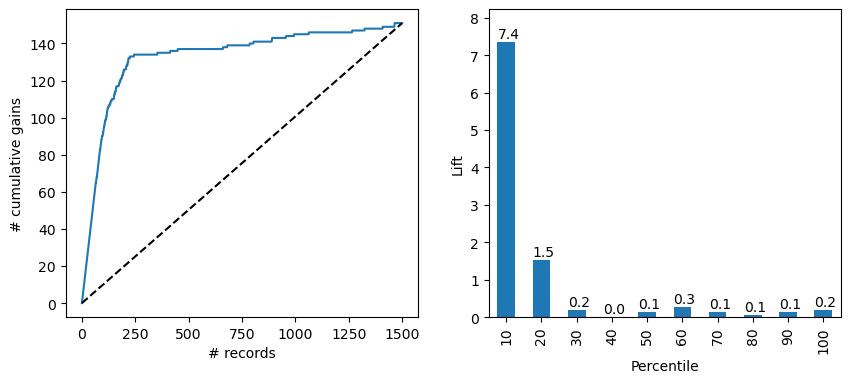

In [22]:
proba = knn5.predict_proba(bank_valid_X)
result = pd.DataFrame({'actual': bank_valid_y, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': knn5.predict(bank_valid_X) })
df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False)
plt.show()

#### The gains chart above shows us the results are much better than random and that we stand to lift by 7.4 and 1.5 for the first two percentiles using the model. We then see the remaining 80% offer negligible improvement. This tells us that its best for the bank to focus on the predicted top 20%.

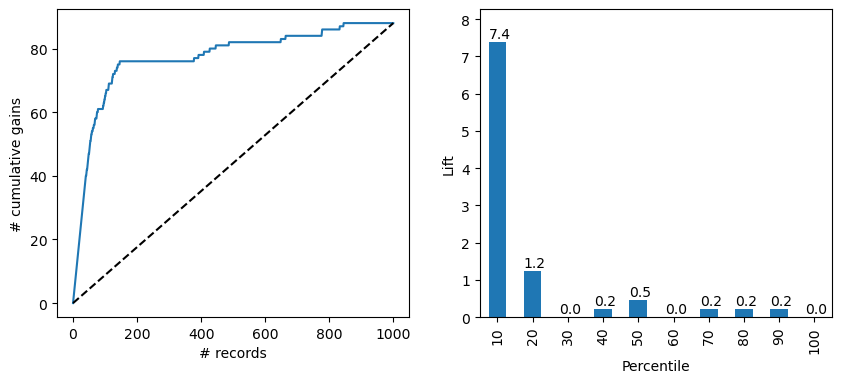

In [21]:
proba = knn5.predict_proba(bank_test_X)
result = pd.DataFrame({'actual': bank_test_y, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': knn5.predict(bank_test_X) })
df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False)
plt.show()

#### #### The gains chart above shows us the results are much better than random and that we stand to lift by 7.4 and 1.2 for the first two percentiles using the model. We then see the remaining 80% offer negligible improvement. The data does seem to indicate there may be some benefit in analyzing the 5th percentile. This tells us that its best for the bank to focus on the predicted top 20%.

# 7.3

In [25]:
dfHouse = readFile("https://raw.githubusercontent.com/wolfesamk/MSBA-206/main/dmba/BostonHousing.csv")
dfHouse = pd.get_dummies(dfHouse.drop(columns='MEDV'), drop_first=False)
print(dfHouse.shape)
dfHouse.head(5)

(506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,1


In [26]:
house_trainData, house_TempData = train_test_split(dfHouse, test_size=0.5, random_state=1)
house_validData, house_testData = train_test_split(house_TempData, test_size=0.4, random_state=1)
print(house_trainData.shape, house_validData.shape, house_testData.shape)

(253, 13) (151, 13) (102, 13)


In [28]:
outcome = 'CAT. MEDV'
predictors = list(dfHouse.columns)
predictors.remove(outcome)
scaler = preprocessing.StandardScaler()
print(predictors)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']


In [29]:
scaler.fit(house_trainData[predictors])
#scaler.transform(train_df[predictors])
# Transform the predictors of training, validation and newCustomer
house_train_X = scaler.transform(house_trainData[predictors])
house_train_y = house_trainData[outcome]
house_valid_X = scaler.transform(house_validData[predictors])
house_valid_y = house_validData[outcome]
house_test_X = scaler.transform(house_testData[predictors])
house_test_y = house_testData[outcome]

In [35]:
results = []
for k in range(1,6):
    knnR = KNeighborsRegressor(n_neighbors=k).fit(house_train_X, house_train_y)
    results.append({
        'k': k,
        'mse': mean_squared_error(house_valid_y, knnR.predict(house_valid_X))
    })
results = pd.DataFrame(results).sort_values(by=['mse'],ascending=True)
print(results)

   k       mse
3  4  0.046772
2  3  0.047829
4  5  0.049007
1  2  0.052980
0  1  0.066225


#### 6.3.a I believe I did the above correctly. Given we want a smaller MSE, a k==4 value is best. It means when doing a KneighbhorsRegressor we want to use the 4 nearest neighbors to predict classification.

#### 7.3.b

In [38]:
newHouse = pd.DataFrame([{'CRIM': 0.2,
                          'ZN': 0,
                          'INDUS': 7,
                          'CHAS': 0,
                          'NOX': 0.538,
                          'RM': 6,
                          'AGE': 62,
                          'DIS': 4.7,
                          'RAD': 4,
                          'TAX': 307,
                          'PTRATIO': 21,
                          'LSTAT': 10}],
                       columns=['CRIM',
                                'ZN',
                                'INDUS',
                                'CHAS',
                                'NOX',
                                'RM',
                                'AGE',
                                'DIS',
                                'RAD',
                                'TAX',
                                'PTRATIO',
                                'LSTAT'])
newHouse


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.2,0,7,0,0.538,6,62,4.7,4,307,21,10


In [41]:
newHouseNorm = pd.DataFrame(scaler.transform(newHouse), 
                               columns=['CRIM',
                                'ZN',
                                'INDUS',
                                'CHAS',
                                'NOX',
                                'RM',
                                'AGE',
                                'DIS',
                                'RAD',
                                'TAX',
                                'PTRATIO',
                                'LSTAT'])
newHouseNorm

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,-0.41485,-0.474983,-0.618182,-0.292979,-0.162626,-0.323022,-0.256416,0.398762,-0.662305,-0.610272,1.187549,-0.444933


In [43]:
knn4 = KNeighborsRegressor(n_neighbors=4).fit(house_train_X, house_train_y)
distances, indices = knn4.kneighbors(newHouseNorm.values)
print(knn4.predict(newHouseNorm.values))
print('Distances',distances)
print('Indices',indices)
print('Training Data\n',house_trainData.iloc[indices[0], :])

[0.]
Distances [[0.41974573 0.84122941 0.94431157 1.06575713]]
Indices [[184 116 188 147]]
Training Data
         CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
15   0.62739  0.0   8.14     0  0.538  5.834  56.5  4.4986    4  307     21.0   
337  0.03041  0.0   5.19     0  0.515  5.895  59.6  5.6150    5  224     20.2   
336  0.03427  0.0   5.19     0  0.515  5.869  46.3  5.2311    5  224     20.2   
321  0.18159  0.0   7.38     0  0.493  6.376  54.3  4.5404    5  287     19.6   

     LSTAT  CAT. MEDV  
15    8.47          0  
337  10.56          0  
336   9.80          0  
321   6.87          0  


#### The new house would be 'CAT. MEDV' 0 meaning its MEDV value is less than 30

#### 7.3.c Given the training set is fitted to the model I would imagine the error rate would be quite Low.

In [45]:
regressionSummary(house_train_y, knn4.predict(house_train_X))


Regression statistics

               Mean Error (ME) : 0.0287
Root Mean Squared Error (RMSE) : 0.1826
     Mean Absolute Error (MAE) : 0.0662


#### Yep, its ME is 0.0287

#### 7.3.d The validation set came from the same dataset as the training data. So its overly optimistic error rate is because the model is designed to fit this data.

In [46]:
regressionSummary(house_valid_y, knn4.predict(house_valid_X))


Regression statistics

               Mean Error (ME) : 0.0149
Root Mean Squared Error (RMSE) : 0.2163
     Mean Absolute Error (MAE) : 0.0877


In [47]:
regressionSummary(house_test_y, knn4.predict(house_test_X))


Regression statistics

               Mean Error (ME) : 0.0294
Root Mean Squared Error (RMSE) : 0.2269
     Mean Absolute Error (MAE) : 0.0882


#### 7.3.e The greatest disadvantage of doing knn on several thousand new tracts lies in the amount of time and computational comparisons are required for every single new tract against all the tracts in the sample data. It would then have to average the values of nearest neighbors to predict the desired outcome.
#### The knn function has to go through the following steps every single time. <br> 1. Calculate the Euclidean distance between the new tract and the data set. <br> 2. Order the data set points by distance ascending <br> 3. Using the selected K value it would then have to determine every new tract's vote.
